In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from itertools import chain
import ast
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib


TARGET_CLASS = "CHM2210"


def get_data():
    df = pd.read_csv("data/full_set.csv")
    # converts strings to arrays
    df['Classes'] = df['Classes'].apply(ast.literal_eval)
    df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
    df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
    df['CRN'] = df['CRN'].apply(ast.literal_eval)

    return df


def preprocess_and_split_data(df, target_class, min_class_count):
    # Filter for students who took the target class
    pidms_with_target_class = df[df['Classes'].apply(lambda x: target_class in x)]['Pidm'].unique()
    df = df[df['Pidm'].isin(pidms_with_target_class)]
    df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]

    # Find the first semester when the target class was taken
    def find_first_semester(student_df):
        target_row = student_df[student_df['Classes'].apply(lambda x: target_class in x)]
        if not target_row.empty:
            return target_row['Semester'].min()
        return None

    first_semester = df.groupby('Pidm').apply(find_first_semester).rename('Target_Semester')
    df = df.merge(first_semester, on='Pidm')

    # Filter all semesters before the target class was taken
    filtered_df = df[df['Semester'] <= df['Target_Semester']]

    # Extract grades and points for the target class
    def find_class_grades(student_df):
        for _, row in student_df.iterrows():
            if target_class in row['Classes']:
                index = row['Classes'].index(target_class)
                return row['Semester Points'][index], row['Semester Grades'][index]
        return None, None

    class_grades = filtered_df.groupby('Pidm').apply(find_class_grades).apply(pd.Series)
    class_grades.columns = ['Target_Points', 'Target_Grade']
    filtered_df = filtered_df.merge(class_grades, on='Pidm')

    # Remove rows with invalid grades
    filtered_df = filtered_df[~filtered_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]
    filtered_df = filtered_df[filtered_df['Semester'] < filtered_df['Target_Semester']]

    # Aggregate data by student
    groupped_df = filtered_df.groupby('Pidm').agg({
        "HS GPA": 'first',
        'Converted_SAT': 'first',
        'Semester Grades': lambda x: sum(x, []),
        'Semester Points': lambda x: sum(x, []),
        'Classes': lambda x: sum(x, []),
        'CRN': lambda x: sum(x, []),
        'Target_Grade': 'first',
        'Target_Points': 'first',
    }).reset_index()

    # Create one-hot encoding for all classes
    all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

    def create_one_hot(classes, points, all_classes):
        one_hot_vector = [-1] * len(all_classes)
        for class_name, point in zip(classes, points):
            if class_name in all_classes:
                one_hot_vector[all_classes.index(class_name)] = point
        return one_hot_vector

    groupped_df['One_Hot_Classes'] = groupped_df.apply(
        lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
    )

    one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

    # Split into train, dev, and test sets
    train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
    dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

    train_set = one_hot_df[one_hot_df.index.isin(train.index)]
    dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
    test_set = one_hot_df[one_hot_df.index.isin(test.index)]

    # Remove features with fewer than min_class_count observations
    columns_to_remove = []
    for column in train_set.columns:
        value_counts = train_set[column].value_counts()
        max_count = value_counts.max()
        non_max_count = value_counts.sum() - max_count
        if non_max_count <= min_class_count:
            columns_to_remove.append(column)

    train_set = train_set.drop(columns=columns_to_remove)
    dev_set = dev_set.drop(columns=columns_to_remove)
    test_set = test_set.drop(columns=columns_to_remove)

    # Integrate additional features
    train_set = train_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])
    dev_set = dev_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])
    test_set = test_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])

    # Map grades to class labels
    grade_mapping = {
    'A+': 0, 'A': 0, 'A-': 0, 'S': 0,  # Class 0: A
    'B+': 1, 'B': 1, 'B-': 1,  # Class 1: B
    'C+': 2, 'C': 2, 'C-': 2,  # Class 2: C
    'D+': 3, 'D': 3, 'D-': 3, 'F': 3, 'U': 3  # Class 3: Fail
    }

    train_set['Target_Class'] = train_set['Target_Grade'].map(grade_mapping)
    dev_set['Target_Class'] = dev_set['Target_Grade'].map(grade_mapping)
    test_set['Target_Class'] = test_set['Target_Grade'].map(grade_mapping)

    # Drop rows with missing target classes
    train_set.dropna(subset=['Target_Class'], inplace=True)
    dev_set.dropna(subset=['Target_Class'], inplace=True)
    test_set.dropna(subset=['Target_Class'], inplace=True)

    # Separate features and targets
    X_train = train_set.drop(columns=['Target_Grade', 'Target_Class'])
    X_dev = dev_set.drop(columns=['Target_Grade', 'Target_Class'])
    X_test = test_set.drop(columns=['Target_Grade', 'Target_Class'])
    y_train = train_set['Target_Class'].astype(int)
    y_dev = dev_set['Target_Class'].astype(int)
    y_test = test_set['Target_Class'].astype(int)

    # Return processed data
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [3]:
df = get_data()
X_train, y_train, X_dev, y_dev, X_test, y_test = preprocess_and_split_data(df, TARGET_CLASS, 20)

C:\Users\artkr\AppData\Local\Temp\ipykernel_34464\2355148745.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(find_first_semester).rename('Target_Semester')
C:\Users\artkr\AppData\Local\Temp\ipykernel_34464\2355148745.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(find_class_grades).apply(pd.Series)


Accuracy: 0.51
Confusion Matrix:
 [[270  83  17   2]
 [113 187  96  13]
 [ 18  98 114  28]
 [  7  35  64  29]]
Classification Report:
               precision    recall  f1-score   support

     A class       0.66      0.73      0.69       372
     B class       0.46      0.46      0.46       409
     C class       0.39      0.44      0.42       258
        Fail       0.40      0.21      0.28       135

    accuracy                           0.51      1174
   macro avg       0.48      0.46      0.46      1174
weighted avg       0.50      0.51      0.50      1174



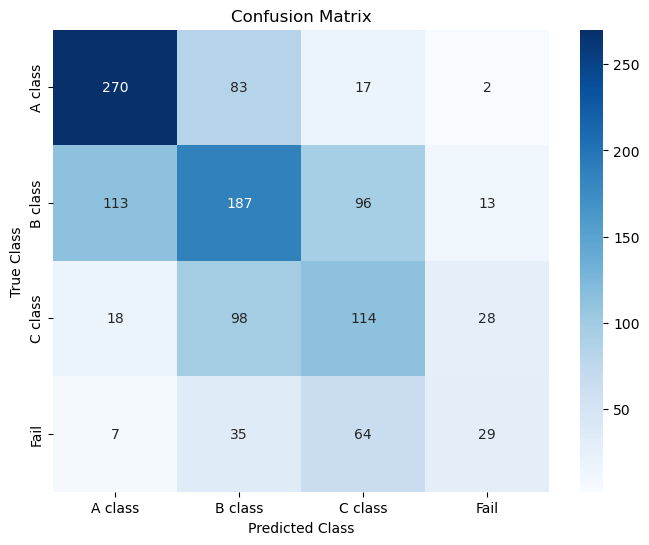

Top 20 Features by Importance:
      Feature  Importance
65    CHM2046    0.030390
63    CHM2045    0.006669
5     AFR2001    0.005176
244   MHS4703    0.004344
200   ISS3420    0.004328
15    ANT3610    0.004200
210   LIS4785    0.004145
136   FRE1120    0.004051
101   EGN3311    0.003969
306   POS2041    0.003711
203   LAH2020    0.003710
254   MUL3011    0.003687
293   PHI4320    0.003676
333   SPC3710    0.003674
6     AMH2010    0.003656
120   ENG4674    0.003654
44   BSC2094C    0.003637
245   MMC2110    0.003578
1     ACG2071    0.003574
35    BSC2010    0.003573


In [4]:
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500,
    'subsample': 0.8,
    'seed': 42,
    'early_stopping_rounds': 50,
    'eval_metric': 'mlogloss'
}
class_names = ['A class', 'B class', 'C class', 'Fail']

# Initialize the XGBoost classifier with your parameters
xgb_classifier = xgb.XGBClassifier(**params)

# Fit the model to the training data
eval_set = [(X_dev, y_dev)]
xgb_classifier.fit(
    X_train, 
    y_train, 
    eval_set=eval_set,
    verbose = 0
)

# Predict on the test set
y_test_pred = xgb_classifier.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Modify classification report with class names
class_report = classification_report(y_test, y_test_pred, target_names=class_names)

# Print evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Get feature importances from the trained model
feature_importances = xgb_classifier.feature_importances_

# Assuming your feature names are in X_train.columns
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 20 features
print("Top 20 Features by Importance:")
print(importance_df.head(20))

# Plot the top 20 feature importances
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
# plt.title('Top 20 Feature Importances')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()



In [5]:
type(X_test[:100])
if isinstance(X_test, pd.DataFrame):
    print("Feature names:", X_test.columns)
else:
    print("Convert X_test to DataFrame.")

Feature names: Index(['ACG2021', 'ACG2071', 'AFA2000', 'AFA4335', 'AFR1101', 'AFR2001',
       'AMH2010', 'AMH2020', 'AMS2270', 'AMS3700',
       ...
       'THE2000', 'THE2252', 'THE4574', 'WOH2030', 'WST2250', 'WST2600',
       'WST3015', 'WST3324', 'HS GPA', 'Converted_SAT'],
      dtype='object', length=357)


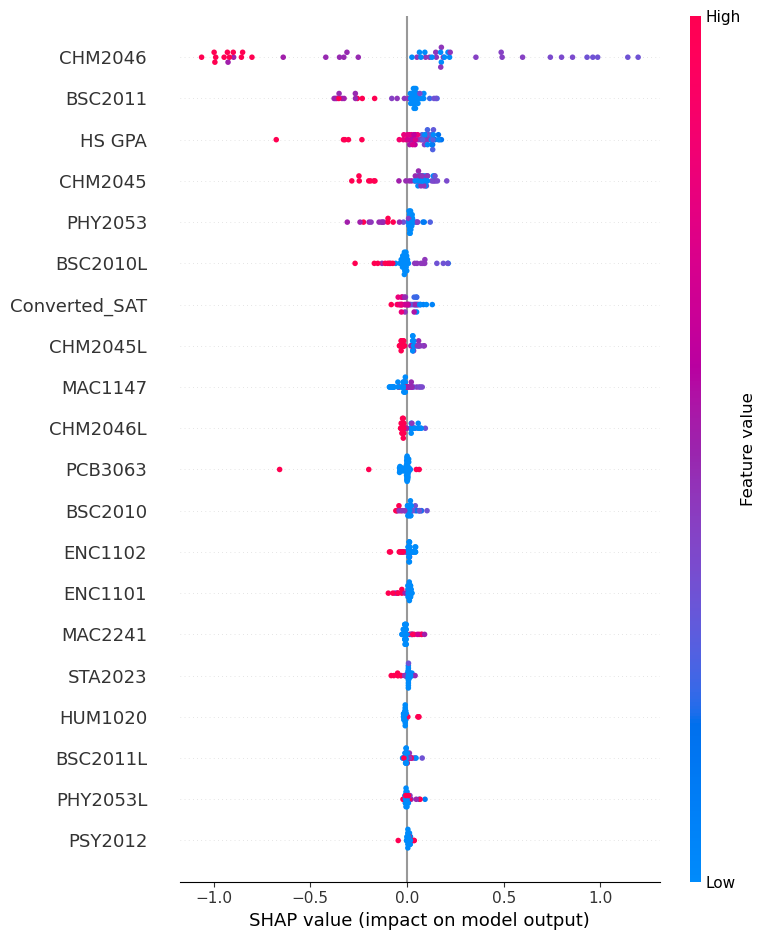

In [ ]:
import shap
X_test_1 = X_test.replace(4.0, 8.0)[:50]
explainer = shap.Explainer(xgb_classifier)

shap_values = explainer(X_test_1)

class_index = 3
shap_values_class = shap_values.values[..., class_index]

shap.summary_plot(shap_values_class, X_test_1, show=True)
# shap.decision_plot(explainer.expected_value[class_index], shap_values_class, X_test, ignore_warnings=True)

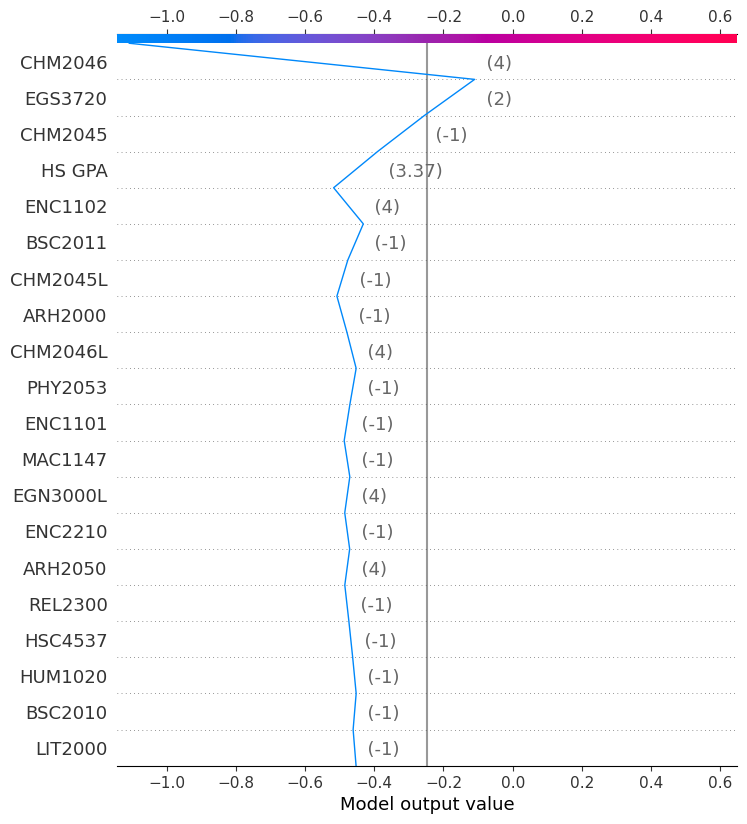

In [58]:
instance_index = 1

class_index = 3
shap_values_class = shap_values.values[..., class_index]

# Extract the SHAP values and feature values for the specific instance
shap_values_instance = shap_values_class[instance_index]
X_test_instance = X_test.iloc[instance_index]

# Plot the SHAP decision plot for the instance
shap.decision_plot(
    base_value=explainer.expected_value[class_index],
    shap_values=shap_values_instance,
    features=X_test_instance,
    ignore_warnings=True
)


# shap.decision_plot(explainer.expected_value[class_index], shap_values_class, X_test[0], ignore_warnings=True)

In [7]:
def save_xgboost_model(X_train, y_train, X_dev, y_dev, params, target_class):
    print(f"Training and saving model for class {target_class}...")
    
    # Initialize the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(**params)

    # Fit the model
    eval_set = [(X_dev, y_dev)]
    xgb_classifier.fit(
        X_train, 
        y_train, 
        eval_set=eval_set, 
        verbose=False
    )

    # Save the model
    model_path = f"./MLP_model_for_{target_class}.h5"
    joblib.dump(xgb_classifier, model_path)
    print(f"Model for class {target_class} saved to {model_path}")


    

# Define XGBoost parameters
xgboost_params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500,
    'subsample': 0.8,
    'seed': 42,
    'early_stopping_rounds': 50,
    'eval_metric': 'mlogloss'
}

# Define class names for better readability
class_labels = ['A class', 'B class', 'C class', 'Fail']

df = get_data()

# Call the preprocessing function to get datasets
X_train, y_train, X_dev, y_dev, X_test, y_test = preprocess_and_split_data(df, TARGET_CLASS, 20)

# Run the XGBoost model
accuracy, class_report = run_xgboost_model(X_train, y_train, X_dev, y_dev, X_test, y_test, xgboost_params, class_labels)

KeyboardInterrupt: 